In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.vaep as vaep

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League") 
              & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

nb of games: 380


In [4]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"atomic_actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        #.merge(players,how="left")
        .merge(teams,how="left",)
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 380/380 [00:23<00:00, 16.32it/s]


Index(['game_id', 'period_id', 'action_id', 'time_seconds', 'timestamp',
       'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id', 'bodypart_id',
       'type_name', 'bodypart_name', 'team_name', 'scores', 'concedes',
       'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [5]:
ty = A.type_name
(ty.shift(1) +ty + (A.player_id == A.shift(1).player_id).apply(str))[ty == "receival"][:1000].value_counts()
A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))
(ty.shift(1) +ty + (A.player_id == A.shift(1).player_id).apply(str))[ty == "receival"][:1000].value_counts()

passreceivalTrue                946
throw_inreceivalTrue             24
clearancereceivalTrue            14
freekick_shortreceivalTrue        6
freekick_crossedreceivalTrue      4
goalkickreceivalTrue              2
corner_crossedreceivalTrue        2
corner_shortreceivalTrue          1
crossreceivalTrue                 1
dtype: int64

### Most valuable players

In [16]:
A["count"] = 1

A_ = A[~A.type_name.isin(["goal","out","penalty_shot","freekick_shot",
                          #"shot"
                         ])]
#,"penalty_shot","freekick_shot","shot"])] # ignore penalties
playersR = (
    A_[["player_id","vaep_value","offensive_value","defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
#playersR = playersR.sort_values("vaep_value",ascending=False)
#playersR[:20]

In [17]:
# Normalize for minutes played
playersR = playersR.merge(players[["player_id","player_nickname","player_name"]],how="left")
playersR["player"] = playersR[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id","player","vaep_value","offensive_value","defensive_value","count"]]

In [18]:
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 900]
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats[stats.offensive_rating > 0.1].sort_values("vaep_rating",ascending=False)[:25]

,player_id,player,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating
34,3089.0,Kevin De Bruyne,6.249833,5.951144,0.298689,2416,1022,0.550377,0.524073
18,3064.0,David Silva,14.568746,13.464730,1.104017,6152,2470,0.530845,0.490618
249,3664.0,Trent Alexander-Arnold,14.852482,11.342112,3.510370,6197,2545,0.525235,0.401096
221,3621.0,Eden Hazard,17.704041,17.432393,0.271648,6460,3051,0.522243,0.514230
338,5111.0,Dwight McNeil,9.094280,7.441047,1.653233,1937,1636,0.500297,0.409349
184,3531.0,Mohamed Salah,18.557568,17.917356,0.640212,4057,3352,0.498264,0.481075
52,3233.0,Raheem Sterling,15.744508,15.240115,0.504393,4569,2865,0.494592,0.478747
277,3814.0,Riyad Mahrez,7.660482,7.247400,0.413083,2795,1401,0.492108,0.465572
234,3647.0,Alex Iwobi,11.218074,10.271449,0.946625,3344,2057,0.490825,0.449407
270,3726.0,Gerard Deulofeu,11.431537,11.011768,0.419769,2663,2111,0.487370,0.469474


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2019-01-19 Liverpool 4-3 Crystal Palace 74' dribble 3531.0


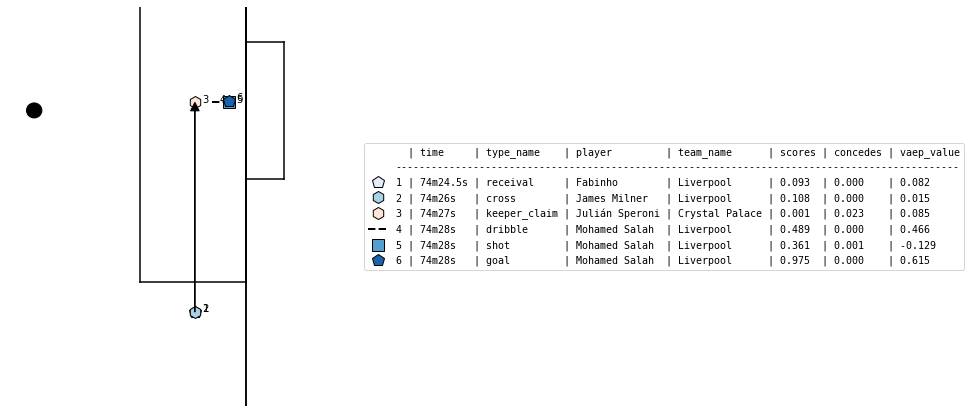

2019-02-04 West Ham United 1-1 Liverpool 43' receival 3473.0


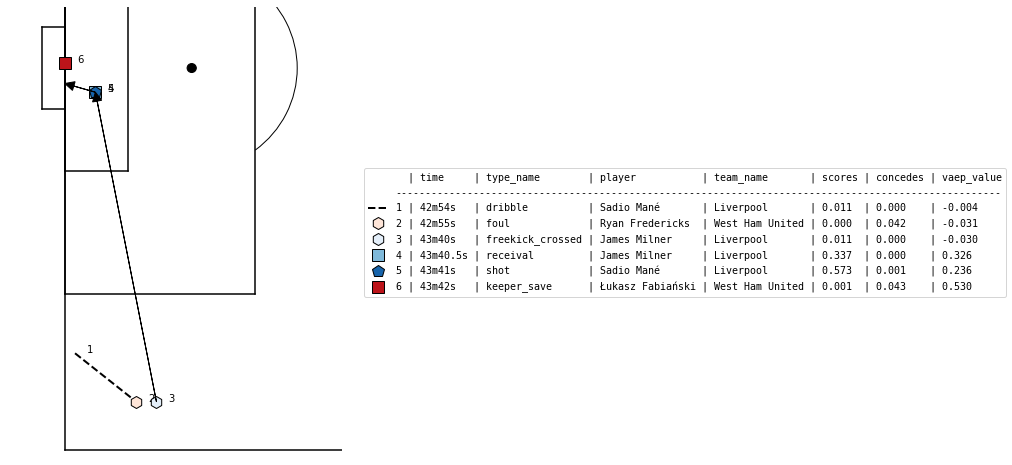

2018-12-26 Fulham 1-1 Wolverhampton Wanderers 84' dribble 5219.0


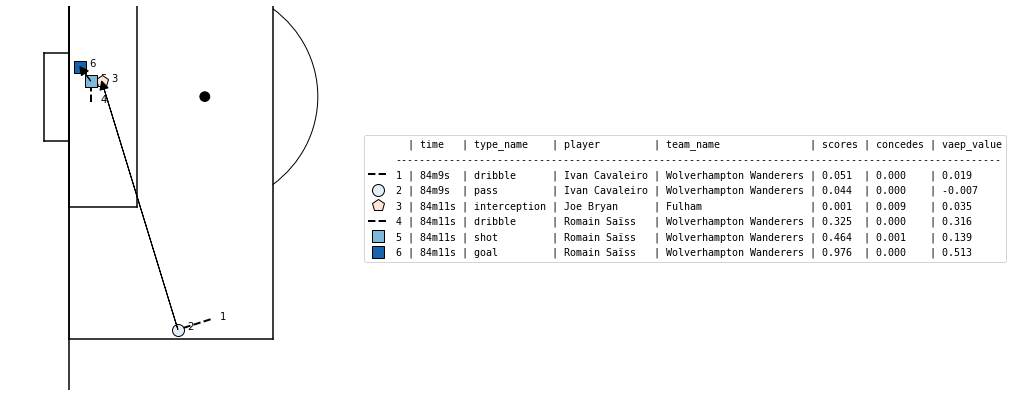

2018-12-15 Tottenham Hotspur 1-0 Burnley 74' interception 10955.0


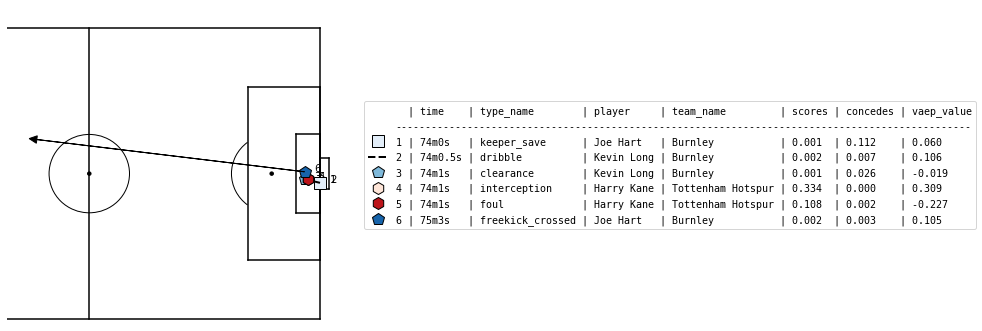

2019-01-30 Tottenham Hotspur 2-1 Watford 51' interception 3486.0


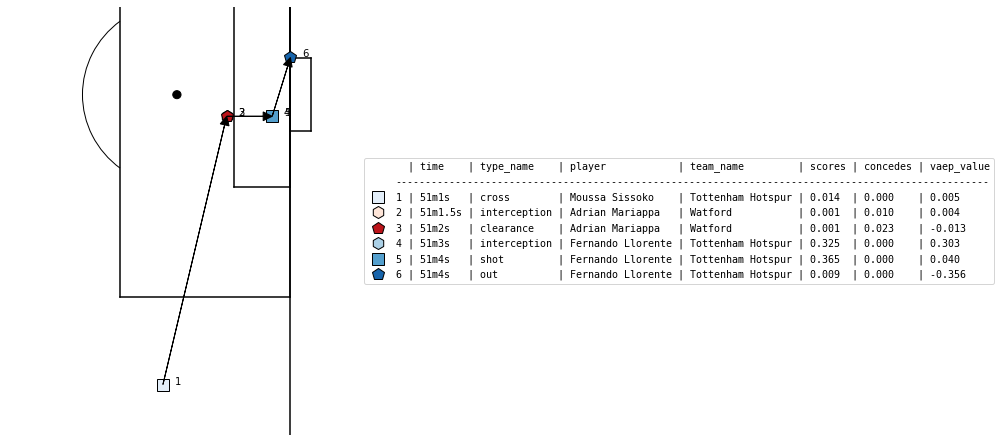

2019-04-13 Burnley 2-0 Cardiff City 91' interception 3505.0


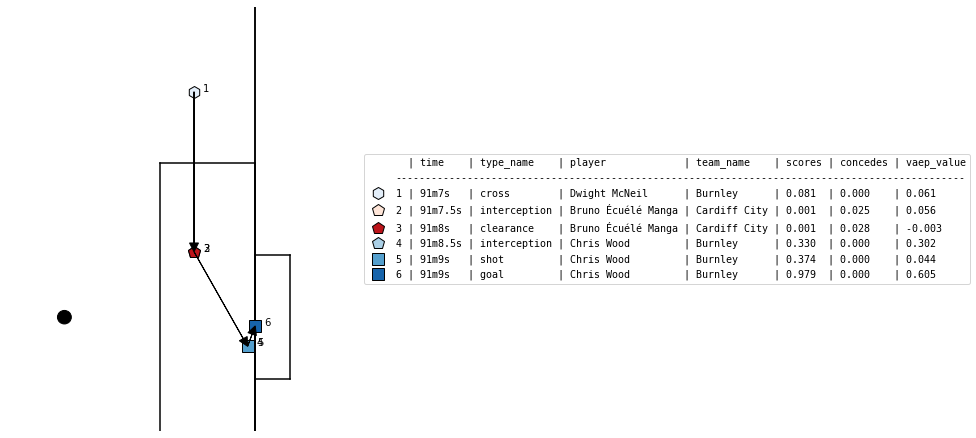

2019-01-02 Newcastle United 0-2 Manchester United 63' dribble 3289.0


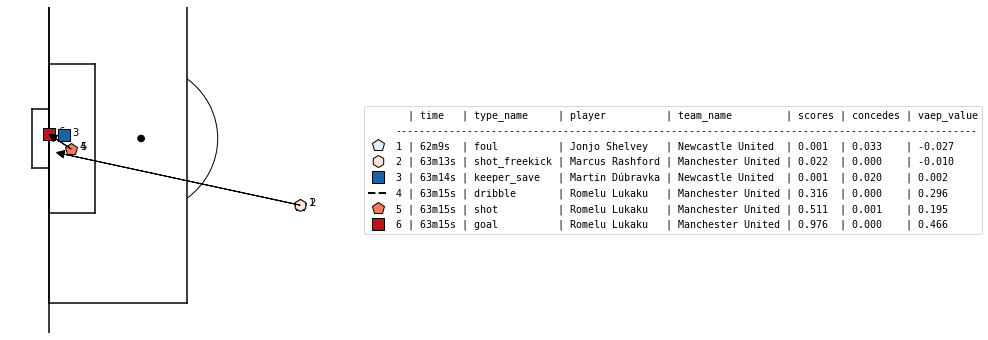

2019-04-13 Burnley 2-0 Cardiff City 64' interception 3505.0


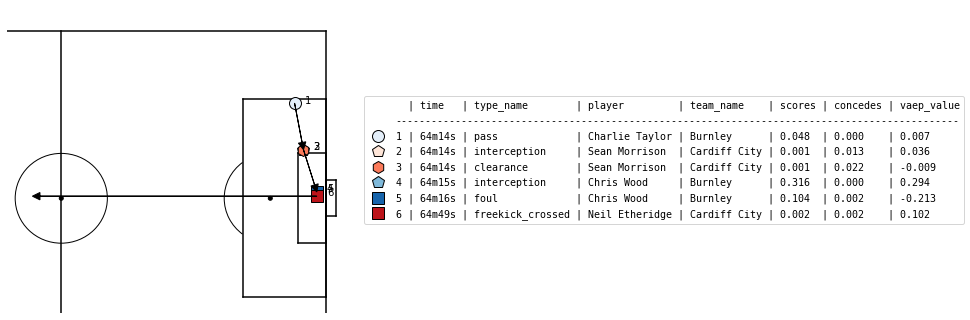

2018-12-26 Burnley 1-5 Everton 90' receival 3720.0


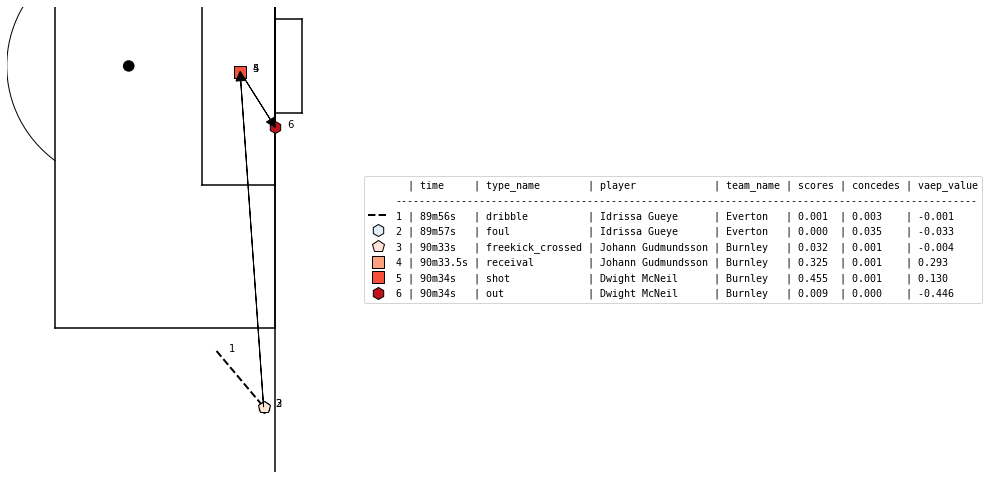

2019-03-17 Fulham 1-2 Liverpool 73' dribble 16441.0


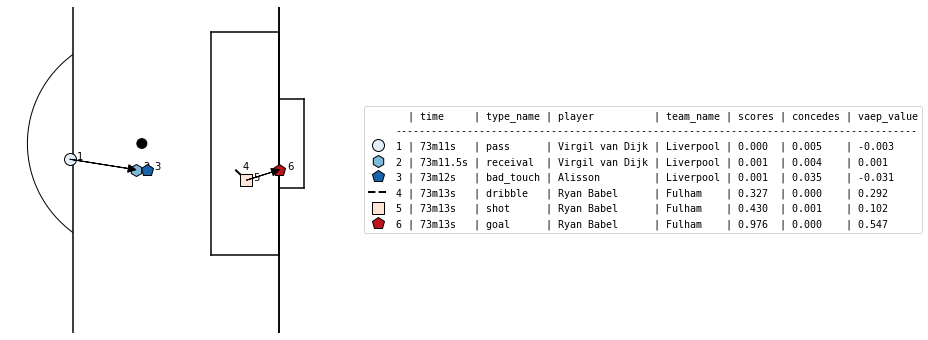

In [26]:
import matplotsoccer

players = pd.read_hdf(spadl_h5,"players")

sorted_A = A.sort_values("offensive_value", ascending=False)
#sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal","shot","shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+3].copy()
    
    a = a.merge(players,how="left")
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","concedes","vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x","y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                #result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=True)